# California Housing — ML Pipeline

This notebook builds on your EDA and creates a reproducible ML pipeline: preprocessing, feature engineering, feature selection, training multiple regression models, cross-validation and hyperparameter tuning. Save or run cells as needed.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

sns.set_style('whitegrid')
RANDOM_STATE = 42


In [2]:
# Load dataset
california = fetch_california_housing(as_frame=True)
housing = california.frame.copy()
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Quick info and describe
print(housing.shape)
housing.info()
housing.describe().T

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [4]:
# Feature engineering: derived features from EDA
housing['RoomsPerHousehold'] = housing['AveRooms'] / np.where(housing['AveOccup']==0, 1, housing['AveOccup'])
housing['BedPerRoom'] = housing['AveBedrms'] / np.where(housing['AveRooms']==0, 1, housing['AveRooms'])
housing['PopulationPerHousehold'] = housing['Population'] / np.where(housing['AveOccup']==0, 1, housing['AveOccup'])
housing[['RoomsPerHousehold','BedPerRoom','PopulationPerHousehold']].head()

,RoomsPerHousehold,BedPerRoom,PopulationPerHousehold
0,2.732919,0.146591,126.0
1,2.956685,0.155797,1138.0
2,2.957661,0.129516,177.0
3,2.283154,0.184458,219.0
4,2.879646,0.172096,259.0


In [5]:
# Train / test split
X = housing.drop('MedHouseVal', axis=1)
y = housing['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(16512, 11) (4128, 11)


In [6]:
# Preprocessing: numeric features scaling + power transform to reduce skew
numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

In [7]:
# Create pipelines for models with feature selection (SelectKBest)
k = 8  # initial selection; can be tuned
feature_selector = SelectKBest(score_func=f_regression, k=k)

def make_pipeline(estimator):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', feature_selector),
        ('estimator', estimator)
    ])

models = {
    'LinearRegression': make_pipeline(LinearRegression()),
    'Ridge': make_pipeline(Ridge(random_state=RANDOM_STATE)),
    'RandomForest': make_pipeline(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    'GradientBoosting': make_pipeline(GradientBoostingRegressor(random_state=RANDOM_STATE))
}

models.keys()

dict_keys(['LinearRegression', 'Ridge', 'RandomForest', 'GradientBoosting'])

In [8]:
# Cross-validation (5-fold) baseline scores (RMSE)
from sklearn.model_selection import cross_validate
cv_results = {}
for name, pipe in models.items():
    scores = cross_validate(pipe, X_train, y_train, cv=5,
                            scoring=('neg_root_mean_squared_error','r2'),
                            return_train_score=False, n_jobs=-1)
    cv_results[name] = {
        'RMSE_mean': -scores['test_neg_root_mean_squared_error'].mean(),
        'RMSE_std': scores['test_neg_root_mean_squared_error'].std(),
        'R2_mean': scores['test_r2'].mean()
    }

import pprint
pprint.pprint(cv_results)

{'GradientBoosting': {'R2_mean': np.float64(0.7214886729534166),
                      'RMSE_mean': np.float64(0.6100326491795448),
                      'RMSE_std': np.float64(0.007350343460636704)},
 'LinearRegression': {'R2_mean': np.float64(0.5827338936033608),
                      'RMSE_mean': np.float64(0.7466950022888147),
                      'RMSE_std': np.float64(0.013012403711371637)},
 'RandomForest': {'R2_mean': np.float64(0.7304842938938403),
                  'RMSE_mean': np.float64(0.600048815714471),
                  'RMSE_std': np.float64(0.005430173023988779)},
 'Ridge': {'R2_mean': np.float64(0.5827409581215944),
           'RMSE_mean': np.float64(0.7466891100465637),
           'RMSE_std': np.float64(0.01300127170936698)}}


In [9]:
# Hyperparameter tuning for RandomForest and GradientBoosting (GridSearchCV)
rf_param_grid = {
    'selector__k': [6, 8, 10, 12],
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [None, 10, 20],
}

gb_param_grid = {
    'selector__k': [6, 8, 10, 12],
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}

gs_rf = GridSearchCV(models['RandomForest'], rf_param_grid, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_gb = GridSearchCV(models['GradientBoosting'], gb_param_grid, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1)

print('Fitting RandomForest GridSearch... (this may take a few minutes)')
gs_rf.fit(X_train, y_train)
print('Best RF params:', gs_rf.best_params_)
print('Fitting GradientBoosting GridSearch...')
gs_gb.fit(X_train, y_train)
print('Best GB params:', gs_gb.best_params_)

Fitting RandomForest GridSearch... (this may take a few minutes)
Best RF params: {'estimator__max_depth': 20, 'estimator__n_estimators': 200, 'selector__k': 10}
Fitting GradientBoosting GridSearch...
Best GB params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 200, 'selector__k': 10}


In [13]:
# Evaluate best estimators on the test set
best_rf = gs_rf.best_estimator_
best_gb = gs_gb.best_estimator_

for name, model in [('RandomForest', best_rf), ('GradientBoosting', best_gb)]:
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Test RMSE: {rmse:.4f}, R2: {r2:.4f}")

RandomForest Test RMSE: 0.2529, R2: 0.8070
GradientBoosting Test RMSE: 0.2236, R2: 0.8294


Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'RoomsPerHousehold', 'BedPerRoom', 'PopulationPerHousehold']
MedInc                    0.523910
AveOccup                  0.127381
Latitude                  0.083260
Longitude                 0.082240
HouseAge                  0.052228
BedPerRoom                0.029571
PopulationPerHousehold    0.027546
RoomsPerHousehold         0.026108
AveRooms                  0.025289
AveBedrms                 0.022468
dtype: float64


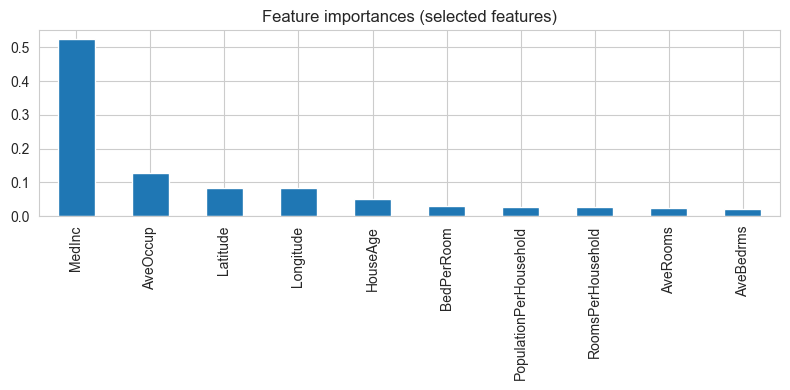

In [11]:
# Inspect selected features and feature importances from the best RandomForest pipeline
# Extract feature names after preprocessing & selection
selector = best_rf.named_steps['selector']
preproc = best_rf.named_steps['preprocessor']

# The SelectKBest uses feature indices from original numeric_features order
selected_indices = selector.get_support(indices=True)
selected_features = [numeric_features[i] for i in selected_indices]
print("Selected features:", selected_features)

# Get feature importances (from estimator)
importances = best_rf.named_steps['estimator'].feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', figsize=(8,4), title='Feature importances (selected features)')
plt.tight_layout()
plt.show()

In [12]:
# Save the best model to disk
joblib.dump(best_rf, 'best_random_forest_california.joblib')
print('Saved best_random_forest_california.joblib')

Saved best_random_forest_california.joblib


## Summary & Next Steps

"
- We built preprocessing that imputes, applies a Yeo-Johnson power transform and scales numeric features.
- We added feature engineering and used SelectKBest to reduce dimensionality.
- Baseline CV was run for several models, then GridSearchCV tuned RandomForest and GradientBoosting.

**Next steps you might take:**
- Try other feature selectors (RFE, permutation importance).
- Use more advanced CV (TimeSeriesSplit if data were temporal) and more extensive hyperparameter search (RandomizedSearchCV).
- Try XGBoost or LightGBM for speed/performance gains.
- Package model with a prediction API (Flask/FastAPI) or export to ONNX for deployment.
